# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from clean_data import convert_to_datetime, clean_profile_data, clean_portfolio_data, clean_transcript_data
from clean_data import create_offer_analysis_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from time import time
from visuals import plot_gender_income_distribution, plot_gender_age_distribution, feature_plot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<h3>Possible Questions</h3>

<ul>
    <li>
        How likely is someone to use the offer based on when they signed up for the app? </li>
        <li>Which offers to send women for certain age range?</li>
        <li>which offers to send men for certain age range?</li>
        <li>which offers should be sent based on income/gender?</li>
    
    
</ul>

<h3>1. Explore the Data</h3>

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', -1)

<h4>1.1 portfolio EDA</h4>

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


check for missing values

In [4]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

There are no missing values in the portfolio dataframe

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


<h4>1.2 profile EDA</h4>

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


<h4>1.2.1 check for missing values</h4>

In [8]:
profile.isnull().sum()

age                 0   
became_member_on    0   
gender              2175
id                  0   
income              2175
dtype: int64

Seems to be 2,175 missing values in the gender and income columns

In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


<h4>1.2.2 View age distribution as there seems to be some entries which are entered as 118</h4>

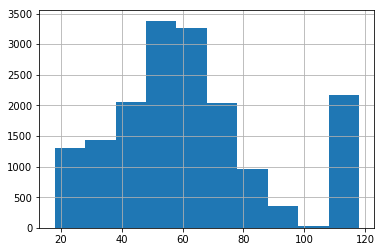

In [10]:
profile.age.hist();

There appears to be a number of age entries which do not make sense. So might be able to drop them.

In [11]:
print(profile[profile['age'] > 110].count())

age                 2175
became_member_on    2175
gender              0   
id                  2175
income              0   
dtype: int64


In [12]:
profile[['gender', 'income', 'age']][profile['age'] > 110].head()

,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


It appears that age 118 corresponds to the null values for the gender and income column so can drop along with the NaNs in the data cleaning steps

<h4>1.2.3 What is the gender distribution?</h4>

In [13]:
profile['gender'].value_counts()

M    8484
F    6129
O    212 
Name: gender, dtype: int64

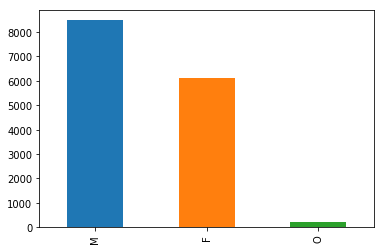

In [14]:
profile['gender'].value_counts().plot(kind="bar");

The gender distribution is as follows: 8,484 men, 6,129 women, and 212 other 

<h4>1.2.4 Explore income distribution</h4>

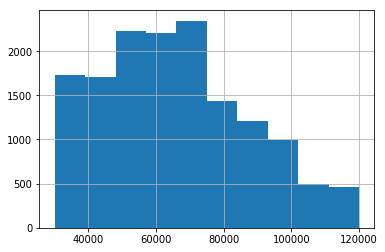

In [15]:
#plot histogram
profile['income'].hist();

It seems that the most commone income range is between 50,000 and 70,000 dollars

<h4>1.2.4 Look at when the customer signed up for the offers</h4>

In [16]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

Determine range of years customers signed up for the app

In [17]:
date_joined = profile['became_member_on'].apply(convert_to_datetime)

#determine year
start_year = date_joined.apply(lambda elem: elem.year).value_counts()
start_year

2017    6469
2018    4198
2016    3526
2015    1830
2014    691 
2013    286 
Name: became_member_on, dtype: int64

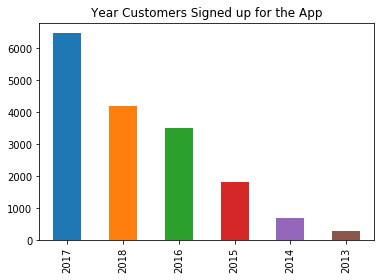

In [18]:
ax = start_year.plot.bar(title='Year Customers Signed up for the App')

It looks like most customers signed up for the app in 2017

Determine range of months when customers signed up for app

In [19]:
start_month = date_joined.apply(lambda elem: elem.month).value_counts()

start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

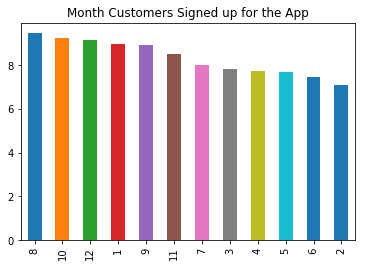

In [20]:
ax = start_month.plot.bar(title='Month Customers Signed up for the App')

October was the most common month for customers to create an account; however, there does not seem to be a large variation between the months. Based on the results, it doesn't seem like the time of year has an impact on when people signed up for the app

<h4>1.3 transcript EDA</h4>

In [21]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


<h4>1.3.1 Find number of missing values</h4>

In [23]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no missing values in the transcript dataframe

<h4>1.3.2 Determime number of different event types.</h4> 

In [24]:
total_events = transcript['event'].value_counts()

Find percent of each event action

In [25]:
#convert value counts results to dataframe to calculate percents
total_events = pd.DataFrame(list(zip(total_events.index.values, total_events)), columns = ['event', 'count'])
total_events

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [26]:
#calculate transaction percent
percent_transaction = (total_events.iloc[0]['count'] / total_events['count'].sum()) * 100
print('The percent transactions out of the total events is:', percent_transaction, '%')

#calculate percent offer received
percent_offer_received = (total_events.iloc[1]['count'] / total_events['count'].sum()) * 100
print('The percent received offers out of the total events is:', percent_offer_received, '%')

#calculate percent offer viewed
percent_offer_viewed = (total_events.iloc[2]['count'] / total_events['count'].sum()) * 100
print('The percent viewed offers out of the total events is:', percent_offer_viewed, '%')

#calculate percent offer completed
percent_offer_completed = (total_events.iloc[3]['count'] / total_events['count'].sum()) * 100
print('The percent completed offers out of the total events is:', percent_offer_completed, '%')

The percent transactions out of the total events is: 45.3303711823 %
The percent received offers out of the total events is: 24.8836996875 %
The percent viewed offers out of the total events is: 18.8315162429 %
The percent completed offers out of the total events is: 10.9544128873 %


<h3>2. Clean Data</h3>

<h4>2.1 Clean portfolio dataframe</h4>

In [27]:
#Use clean_portfolio_data function from clean_data helper file to return cleaned portfolio dataframe
portfolio = clean_portfolio_data(portfolio)

In [28]:
portfolio.head()

,offer_id,bogo,discount,informational,difficulty,days_duration,reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,10,5,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,1,0,4,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,20,10,5,1,0,0,1


<h4>2.2 Clean profile dataframe</h4>

In [29]:
#Use clean_profile_data function from clean_data helper file to return cleaned profile and a separate age and 
#gender dataframe
profile, age_gender_income_df = clean_profile_data(profile)

In [30]:
profile.head()

,customer_id,income,F,M,membership_start_year,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,2017,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,2017,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,70000.0,0,1,2018,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,2018,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,2017,0,0,0,0,0,1,0,0,0,0


In [31]:
age_gender_income_df.head()

,age,M,F,income
0,55,0,1,112000.0
1,75,0,1,100000.0
2,68,1,0,70000.0
3,65,1,0,53000.0
4,58,1,0,51000.0


<h4>2.3 Clean transcript dataframe</h4>

In [32]:
#Use clean_transcript_data function from clean_data helper file to return cleaned offer_df and 
#transaction_df dataframes
offer_df, transaction_df = clean_transcript_data(transcript, profile)

Percentage of transactions removed: 11.02 %


/home/workspace/clean_data.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['time'] /= 24.0


In [33]:
offer_df.head()

,offer_id,customer_id,days,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


In [34]:
transaction_df.head()

,customer_id,days,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [35]:
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148805 entries, 0 to 148804
Data columns (total 6 columns):
offer_id       148805 non-null object
customer_id    148805 non-null object
days           148805 non-null float64
completed      148805 non-null uint8
received       148805 non-null uint8
viewed         148805 non-null uint8
dtypes: float64(1), object(2), uint8(3)
memory usage: 3.8+ MB


In [36]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123957 entries, 0 to 123956
Data columns (total 3 columns):
customer_id    123957 non-null object
days           123957 non-null float64
amount         123957 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


<h4>2.4 Combine portfolio, profile, offer_df, and transaction_df dataframes</h4>

In [37]:
#Use create_offer_analysis_dataset function from clean_data helper file to return a dataframe which combines
#the profile data, portfolio data, offer_df, and transaction_df data.
#Note that this step takes several minutes to complete.
combined_df = create_offer_analysis_dataset(profile, portfolio, offer_df, transaction_df)

In [38]:
#move offer_id and total_amounts columss to front of dataframe to make easier to work with dataframe
column_ordering = ['offer_id', 'total_amount']

#move offer_id and total_amount columns to beginning of dataframe
column_ordering.extend([i for i in combined_df.columns if i not in column_ordering])

combined_df = combined_df[column_ordering]
combined_df.head()

,offer_id,total_amount,F,M,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)",...,"[90, 100)",bogo,completed,days_duration,difficulty,discount,income,informational,membership_start_year,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,0,0,0,0,0,0,0,...,0,1,1,7,5,0,100000.0,0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,100000.0,1,2017,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,0,0,0,0,0,0,0,...,0,1,1,7,10,0,100000.0,0,2017,10
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,0,0,0,0,0,0,0,...,0,1,1,5,5,0,100000.0,0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,1,0,0,0,0,0,0,...,0,0,0,7,10,1,70000.0,0,2018,2


In [39]:
combined_df.head()

,offer_id,total_amount,F,M,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)",...,"[90, 100)",bogo,completed,days_duration,difficulty,discount,income,informational,membership_start_year,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,0,0,0,0,0,0,0,...,0,1,1,7,5,0,100000.0,0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,100000.0,1,2017,0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,0,0,0,0,0,0,0,...,0,1,1,7,10,0,100000.0,0,2017,10
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,0,0,0,0,0,0,0,...,0,1,1,5,5,0,100000.0,0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,1,0,0,0,0,0,0,...,0,0,0,7,10,1,70000.0,0,2018,2


<h3>3. Statistics </h3>

<h4>3.1 Profile DataFrame Stats </h4>

<h4>3.1.1 General income stats</h4>

In [40]:
#get stats for income column
profile[profile['income'].notnull()].describe()

,income,F,M,membership_start_year,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,65404.991568,0.413423,0.572277,2016.620169,0.013828,0.001147,0.092344,0.102934,0.155750,0.238853,0.201754,0.120202,0.056054,0.017133
std,21598.299410,0.492464,0.494765,1.198245,0.116781,0.033845,0.289521,0.303883,0.362631,0.426397,0.401323,0.325209,0.230034,0.129772
min,30000.000000,0.000000,0.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,0.000000,0.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64000.000000,0.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80000.000000,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120000.000000,1.000000,1.000000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h4>3.1.2 Income distribution for Men and Women </h4>

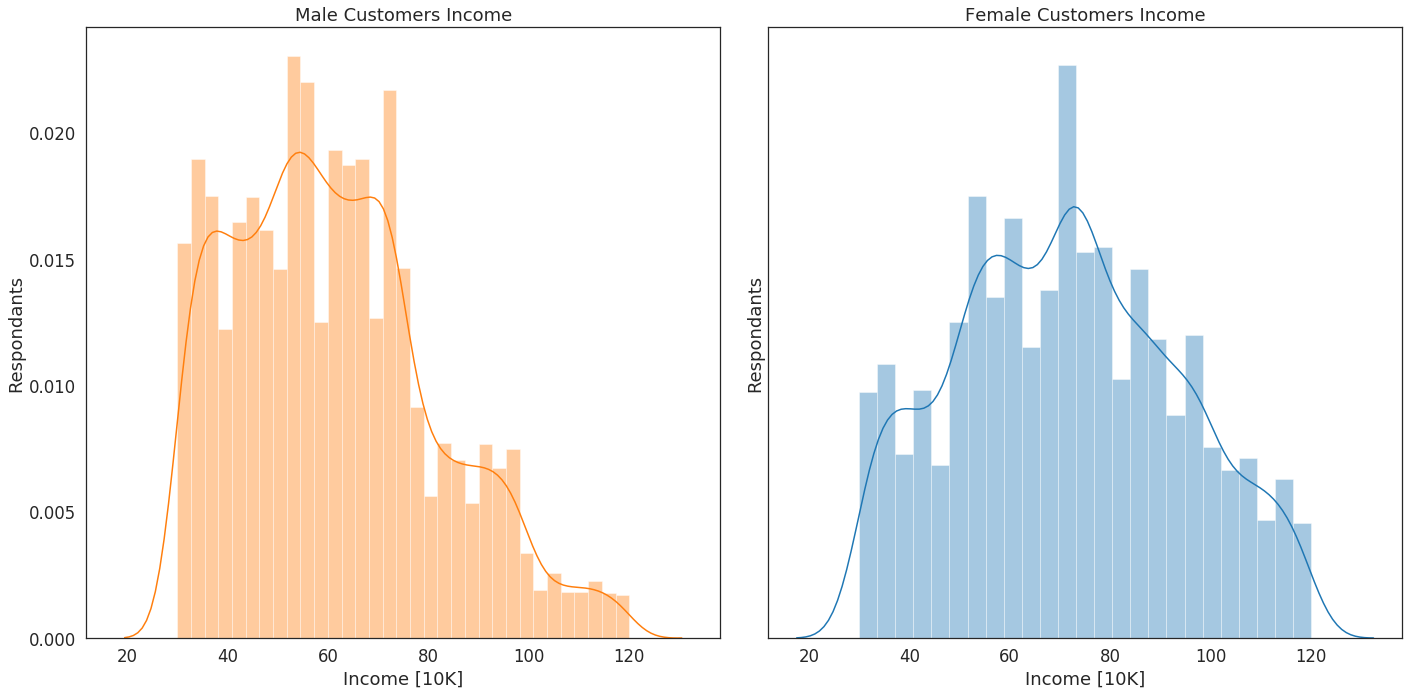

In [41]:
#use plot_gender_income_distribution function from visuals helper file
plot_gender_income_distribution(profile)

The men tended to have a lower income distribution with a peak around 60,000 dollars than the females with a peak around 80,000 dollars who used the app

<h4>3.1.3 Income distribution by Age </h4>

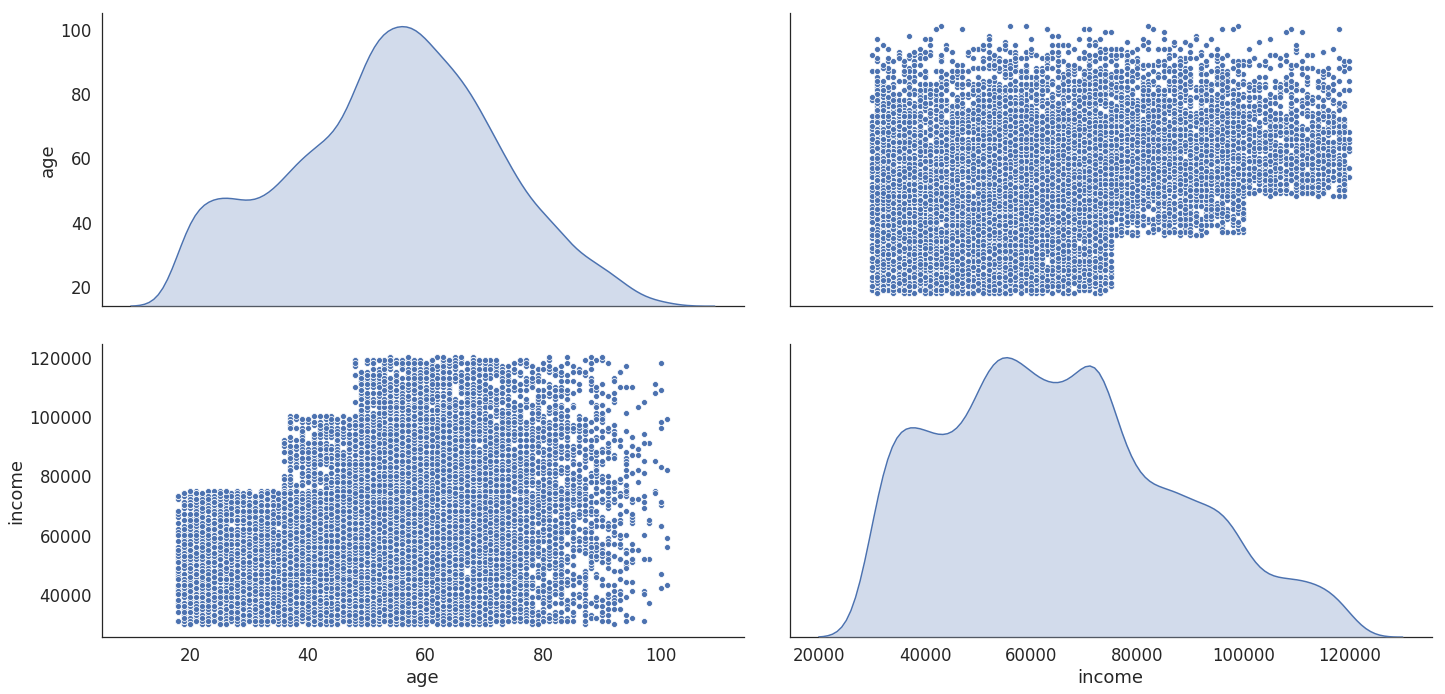

In [42]:
#plot income vs age as scatter plot.
g = sns.pairplot(age_gender_income_df[['age','income']],diag_kind="kde", height=5, aspect=2)

Income and age don't appear to have very good relation based on the above plots.

<h4>3.1.3 When did people tend to join? </h4>

In [43]:
profile[profile['membership_start_year'].notnull()].describe()

,income,F,M,membership_start_year,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,65404.991568,0.413423,0.572277,2016.620169,0.013828,0.001147,0.092344,0.102934,0.155750,0.238853,0.201754,0.120202,0.056054,0.017133
std,21598.299410,0.492464,0.494765,1.198245,0.116781,0.033845,0.289521,0.303883,0.362631,0.426397,0.401323,0.325209,0.230034,0.129772
min,30000.000000,0.000000,0.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49000.000000,0.000000,0.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64000.000000,0.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80000.000000,1.000000,1.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120000.000000,1.000000,1.000000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
profile[profile['membership_start_year'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 15 columns):
customer_id              14825 non-null object
income                   14825 non-null float64
F                        14825 non-null uint8
M                        14825 non-null uint8
membership_start_year    14825 non-null int64
[10, 20)                 14825 non-null uint8
[100, 110)               14825 non-null uint8
[20, 30)                 14825 non-null uint8
[30, 40)                 14825 non-null uint8
[40, 50)                 14825 non-null uint8
[50, 60)                 14825 non-null uint8
[60, 70)                 14825 non-null uint8
[70, 80)                 14825 non-null uint8
[80, 90)                 14825 non-null uint8
[90, 100)                14825 non-null uint8
dtypes: float64(1), int64(1), object(1), uint8(12)
memory usage: 637.0+ KB


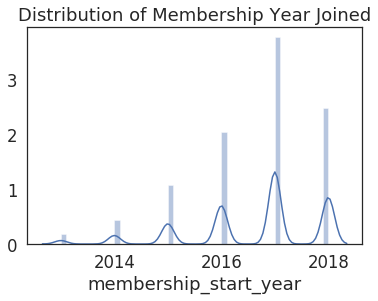

In [45]:
sns.distplot(profile['membership_start_year']).set_title("Distribution of Membership Year Joined");

It seems that most customers joined the app in 2017

<h4>3.1.4 Customers age range </h4>

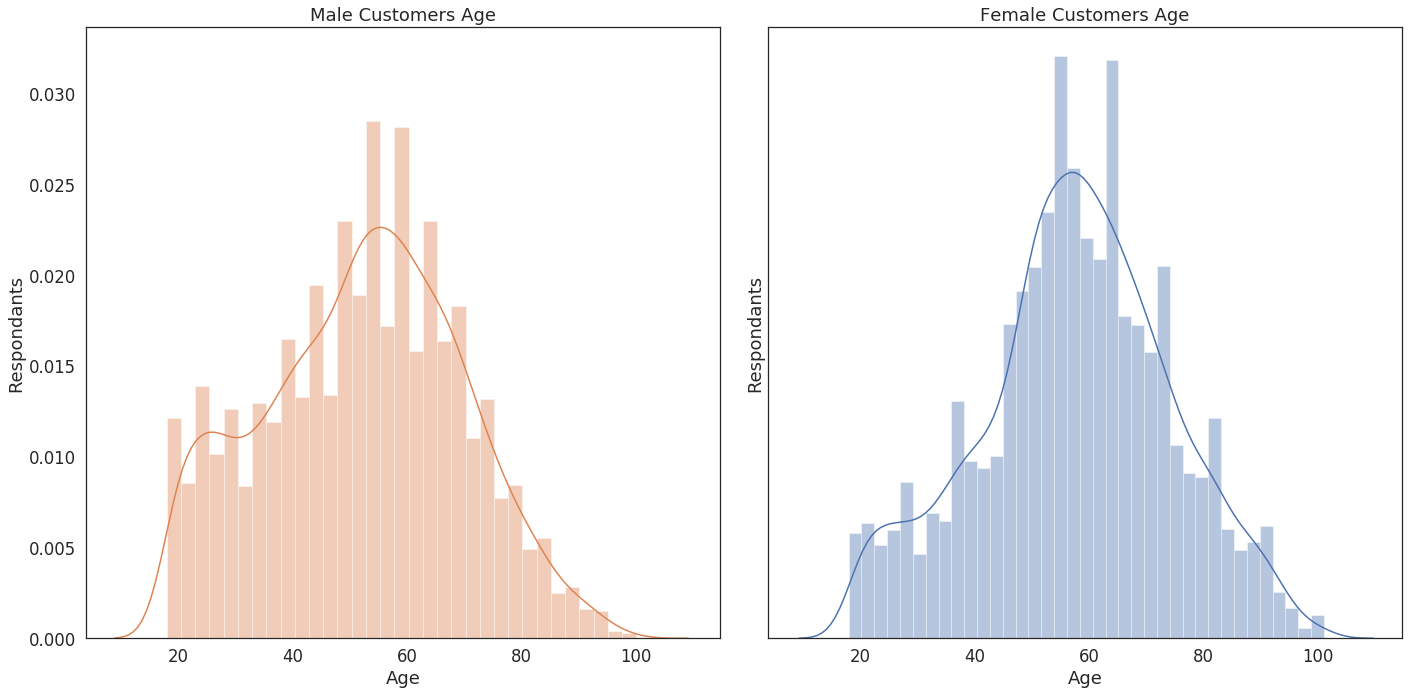

In [46]:
#use plot_gender_age_distribution function from visuals helper file
plot_gender_age_distribution(age_gender_income_df)

On average it appears that more men between ages 20 to 40 use the app, while more women 40 and older seem to use the app then men of similiar age

<h4>3.2 Transcript and offer Data Stats</h4>

In [47]:
transcript.describe()

,days
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [48]:
offer_df.describe()

,days,completed,received,viewed
count,148805.000000,148805.000000,148805.000000,148805.000000
mean,14.773759,0.218030,0.446900,0.335069
std,8.262971,0.412909,0.497174,0.472016
min,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,0.000000
50%,17.000000,0.000000,0.000000,0.000000
75%,21.250000,0.000000,1.000000,1.000000
max,29.750000,1.000000,1.000000,1.000000


In [49]:
transaction_df.describe()

,days,amount
count,123957.000000,123957.000000
mean,15.886592,13.996325
std,8.409545,31.749420
min,0.000000,0.050000
25%,8.750000,3.660000
50%,16.750000,10.800000
75%,23.000000,19.130000
max,29.750000,1062.280000


<h4>3.2.1 Relationship between offer length and offer completion </h4>

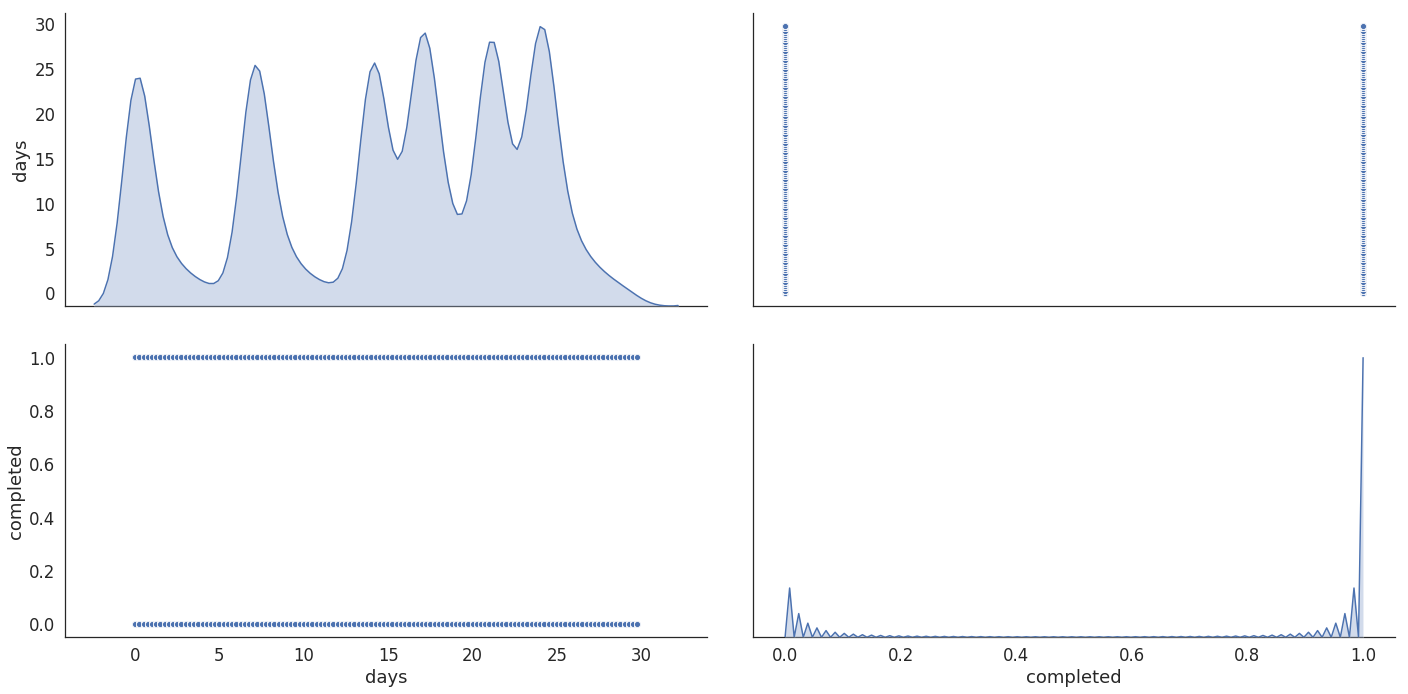

In [50]:
#plot days vs completed scatter plot.
g = sns.pairplot(offer_df[['days','completed']],diag_kind="kde", height=5, aspect=2)

From the plots above, 

<h4>3.2.2 Relationship between offer length and offer amount </h4>

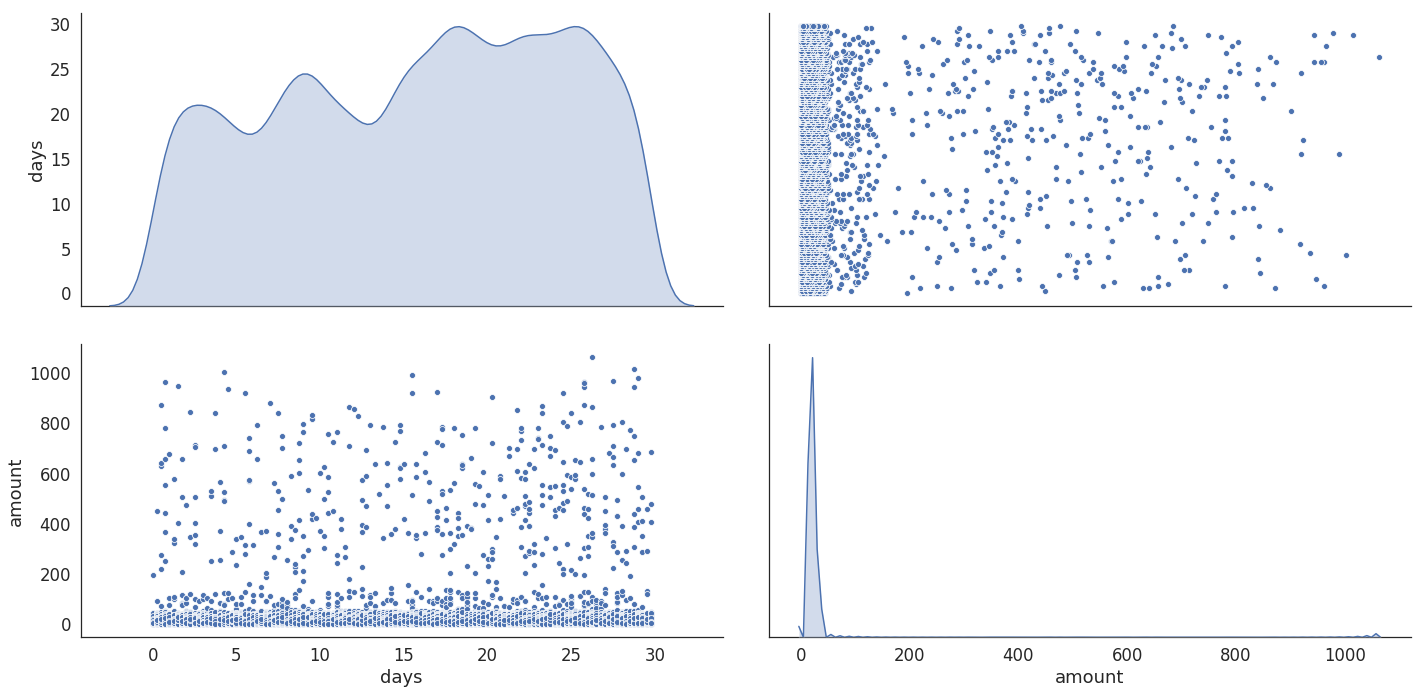

In [51]:
#plot days vs amount.
g = sns.pairplot(transaction_df[['days','amount']],diag_kind="kde", height=5, aspect=2)

<h4>3.3 portfolio data stats</h4>

In [52]:
portfolio.describe()

,bogo,discount,informational,difficulty,days_duration,reward,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.400000,0.400000,0.200000,7.700000,6.500000,4.200000,1.0,0.900000,0.600000,0.800000
std,0.516398,0.516398,0.421637,5.831905,2.321398,3.583915,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,8.500000,7.000000,4.000000,1.0,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000


<h4>3.3.1 Cleaned Portfolio DataFrame Exploration Plots</h4>

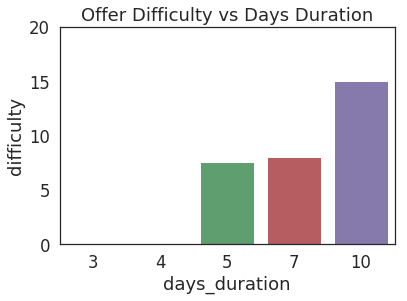

In [53]:
#Plot days_duration vs difficulty
bp = sns.barplot(x="days_duration",y="difficulty",data = portfolio, ci=None).set_title("Offer Difficulty vs Days Duration")
axes = bp.axes
axes.set_ylim(0,20)
plt.show()

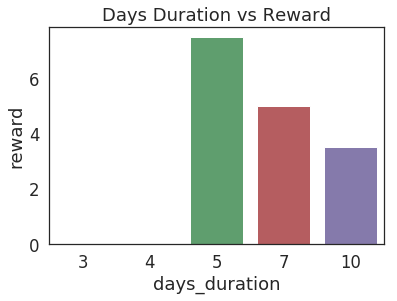

In [54]:
#Plot days_duration vs reward
bp = sns.barplot(x="days_duration",y="reward",data = portfolio, ci=None).set_title("Days Duration vs Reward");
axes = bp.axes
axes.set_ylim(0,)
plt.show()

 <h3>4. Prediction Models</h3>

<h4> 4.1 Set feature to be predicted </h4>

In [55]:
#feature to be predicted
target_name = 'completed'

#features to train the model
variables = combined_df.drop(columns=[target_name, 'offer_id'])

#copy target dataframe for predicition
target = combined_df.filter([target_name])

<h4> 4.2 Split the data into training and testing </h4>


In [56]:
# Split the 'features' and 'income' data into training and testing sets
random_state = np.random.RandomState(0)
        
X_train, X_test, y_train, y_test = train_test_split(variables, target,
                                                    test_size = 0.2, 
                                                    random_state = random_state)

variable_names = variables.columns[2:]

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 53200 samples.
Testing set has 13301 samples.


In [57]:
X_train.head()

,total_amount,F,M,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)",...,"[80, 90)","[90, 100)",bogo,days_duration,difficulty,discount,income,informational,membership_start_year,reward
46365,19.74,0,1,0,0,0,0,1,0,0,...,0,0,0,10,10,1,57000.0,0,2018,2
21887,19.31,0,1,0,0,0,0,0,0,1,...,0,0,1,5,5,0,43000.0,0,2016,5
35727,5.22,0,1,0,0,1,0,0,0,0,...,0,0,0,7,10,1,30000.0,0,2017,2
47543,5.95,0,1,0,0,0,0,1,0,0,...,0,0,0,7,7,1,72000.0,0,2018,3
40037,91.19,1,0,0,0,0,0,0,0,0,...,0,0,0,7,7,1,103000.0,0,2016,3


 <h4>4.3 Perform Naive Bayes predictor</h4>

In [58]:
#naive predictor
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print('Naive predictor accuracy: %.3f' % (naive_predictor_accuracy))
print('Naive predictor f1-score: %.3f' % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


<h4>4.4 Model Tuning </h4>

In [59]:
#Initialize the classifier
clf = RandomForestClassifier(random_state = 40, n_estimators=100)

#Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV
grid_obj = GridSearchCV(clf, parameters, cv=5, scoring=scorer)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

#get the best estimator
best_clf = grid_fit.best_estimator_

#make predictions using the unoptimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

#report before and after scores
print('Unoptimized model\n-----')
print('Accuracy score on testing data:{:.4f}'.format(accuracy_score(y_test, predictions)))
print('F-score on testing data:{:.4f}'.format(fbeta_score(y_test, predictions, beta=0.5)))
print('\nOptimized model\n-----')
print('Final accuracy score on testing data:{:.4f}'.format(accuracy_score(y_test, best_predictions)))
print('Final F-score on testing data:{:.4f}'.format(fbeta_score(y_test, best_predictions, beta=0.5)))

Unoptimized model
-----
Accuracy score on testing data:0.9048
F-score on testing data:0.8939

Optimized model
-----
Final accuracy score on testing data:0.9124
Final F-score on testing data:0.8943


<ul>
<li>The unoptimized model has an Accuracy Score on the testing data of 0.9048 and an F-score of 0.8939</li>
<li>The optimized model has an Accuracy Score on the testing data of 0.9124 and an F-score of 0.8942</li>
</ul>
Optimizing the model using GridSearchCV improves the accuracy and F-score of the model.

<h4>4.5 Feature Importance</h4>

In [60]:
#Import Random Forest Classifier model that has 'feature_importances_'
clf = RandomForestClassifier(random_state = 600)

#Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

#Build important features dictionary from Random Forest Classifier
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    important_features_dict[x]=i

#Save features dictionary to dataframe
feature_importance = pd.DataFrame(list(zip(variable_names, important_features_dict)),
                 columns=['feature', 'importance'])

#sort feature_importance dataframe by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

print('Most important features: %s' %feature_importance)

Most important features:                   feature  importance
18  reward                 18        
17  membership_start_year  17        
16  informational          16        
15  income                 15        
14  discount               14        
13  difficulty             13        
12  days_duration          12        
11  bogo                   11        
10  [90, 100)              10        
9   [80, 90)               9         
8   [70, 80)               8         
7   [60, 70)               7         
6   [50, 60)               6         
5   [40, 50)               5         
4   [30, 40)               4         
3   [20, 30)               3         
2   [100, 110)             2         
1   [10, 20)               1         
0   M                      0         


<h4>4.5.1 Plot Random Forest Feature Importance</h4>

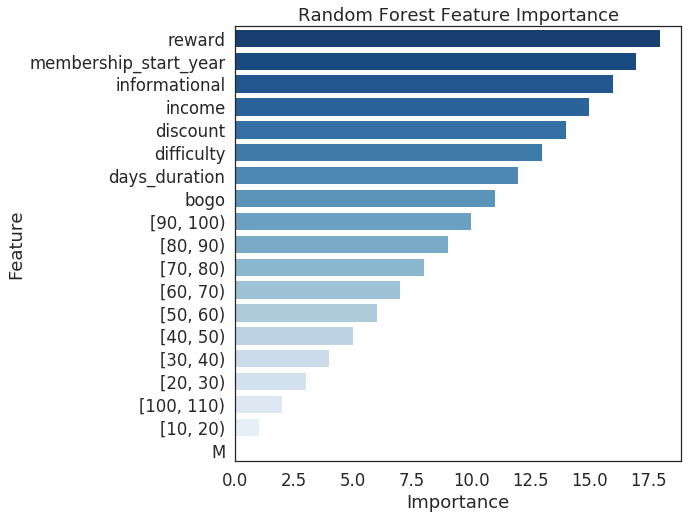

In [61]:
#Plot features using feature_plot function from visuals helper file
feature_plot(feature_importance)

<h4>4.6 LightGBM</h4>

In [62]:
# create dataset for lightgbm from training and testing data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [63]:
#tune parameters
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
#params['metric'] = ('l1', 'l2')
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 500
params['max_depth'] = 100

In [64]:
print('Starting training...')
# train
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                feature_name = list(X_train),
                evals_result=evals_result,
                early_stopping_rounds=5,
                verbose_eval=20)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

Starting training...
Training until validation scores don't improve for 5 rounds.
[20]	valid_0's binary_logloss: 0.664878
[40]	valid_0's binary_logloss: 0.641285
[60]	valid_0's binary_logloss: 0.621423
[80]	valid_0's binary_logloss: 0.599656
[100]	valid_0's binary_logloss: 0.579538
[120]	valid_0's binary_logloss: 0.55751
[140]	valid_0's binary_logloss: 0.539713
[160]	valid_0's binary_logloss: 0.524786
[180]	valid_0's binary_logloss: 0.512667
[200]	valid_0's binary_logloss: 0.497267
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.497267
Saving model...


In [65]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
#convert to binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

Starting predicting...


<h4>4.6.1 Plot metrics</h4>

Plotting metrics recorded during training...


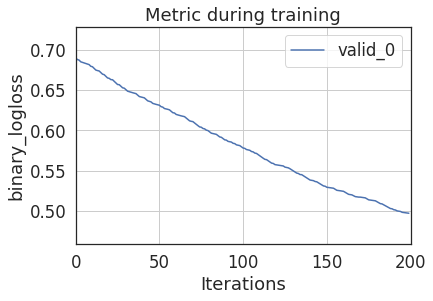

In [66]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

<h4>4.6.2 Plot LightGBM Feature Importance</h4>

Plotting feature importances...


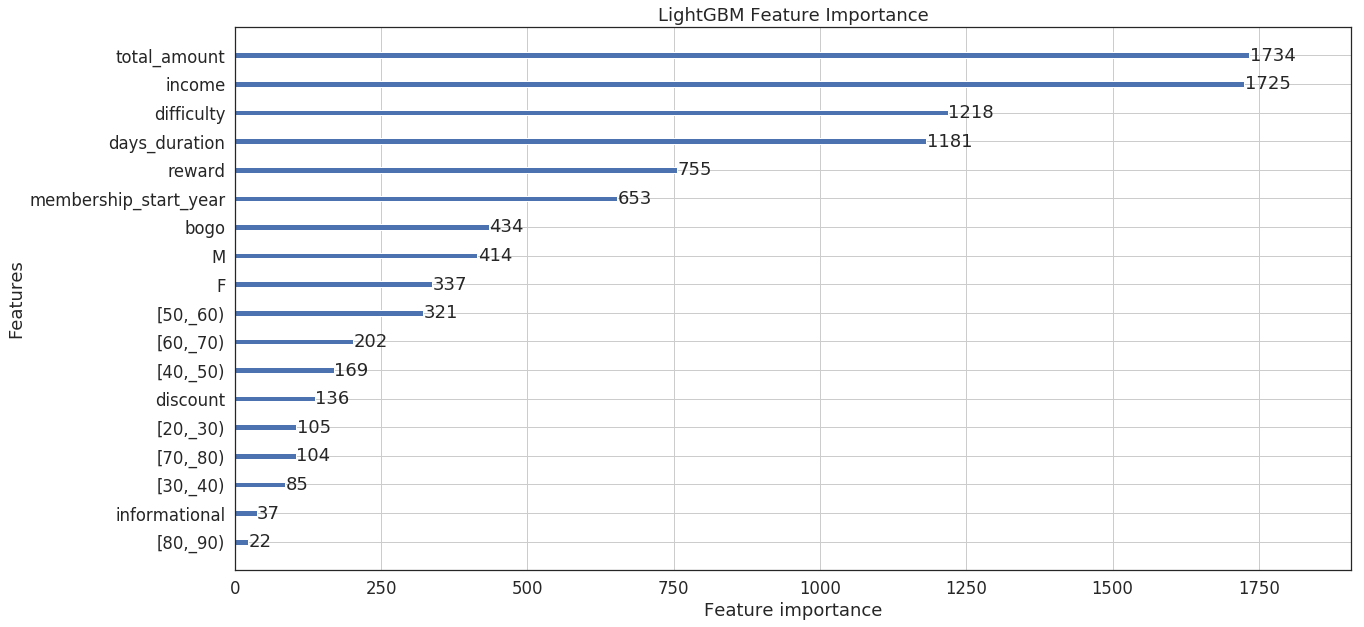

In [71]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20, figsize=(20,10), title='LightGBM Feature Importance')
plt.show()

<h4>4.6.3 Create confusion matrix and measure accuracy of LightGBM model</h4>

In [68]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:', cm)

#Accuracy
accuracy=accuracy_score(y_pred,y_test)
print('LightGBM accuracy:', accuracy)

Confusion Matrix: [[6244  754]
 [ 424 5879]]
LightGBM accuracy: 0.911435230434


<h3>Conclusion</h3>

The problem I chose to solve was to determine whether or not a customer will respond to an offer through the Starbucks app. I approached the problem using two methods, determining the most influential features and implementing a predictive model which can be used to determine if a customer will complete and offer.
I accomplished this task through the following steps:
<ul>
    <li>Exploring the data </li>
    <li>Cleaning the data</li>
    <li>Explore Data Statistics</li>
    <li>Implement Prediction Models</li>
    
</ul>

Through exploring the data and cleaning the data, the three data files provided (portfolio, profile and transcript) were combined into one dataframe in order to split into training at testing sets. 
The data statistics section provided insight into the relationship between features such as gender and income, age and income, and length of offer and offer reward. 

The top features according to the Random Forest Model are:
<ul>
    <li>Offer reward</li>
    <li>Membership start year </li>
    <li>Informational type of offer </li>
    <li>Customer's income </li>
    <li>Discount offer type </li>
</ul>

The top features according to the LightGBM Model are:
<ul>
    <li>Total amount spend by customer</li>
    <li>Customer's income </li>
    <li>Offer difficulty </li>
    <li>Length of offer </li>
    <li>Offer reward </li>
</ul>


The best model prediction method was chosen by comparing the accuracy and F-score of a Naive Bayes model, Random Forest, and the accuracy of LightBGM model. 
<ul>
    <li>Naive predictor accuracy: 0.471
        Naive predictor f1-score: 0.640 </li>
    <li> Optmizied Random Forest accuracy: 0.9124
f1-score: 0.8943</li>
    <li> LightGBM accuracy: 0.9114</li>
</ul>

The Random Forest model had the highest accuracy of 0.9124 while the LightGBM model had an accuracy score of 0.9114. However, the LightGBM model had a signficantly faster computation time. To achieve such a high accuracy and F-score for the Random Forest model, the model had to optimized using the GridSearchCV algorithim, adding approximately an additional 20 minutes of computation time while the LightGBM model had a much faster computation time. Since the accuracy scores are so close, the LightGBM model seems to be the better model for prediction in this case.
